Implements algorithm 3 (ModMod) from Algorithms for "Approx Min of the Difference Between Submodular Fncs with Applications."

For prob_ssm

In [1]:
import torch
from torch import distributions as dist

import itertools
import pickle
import operator
import importlib

import random
import math
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'axes.labelsize': 35})
plt.rcParams.update({'legend.fontsize': 30})
plt.rcParams.update({'axes.titlesize': 16})

from gptorch import kernels, models

import helpers, opt

In [12]:
with open('../inputs/gb1.pkl', 'rb') as f:
    t = pickle.load(f)

X = t[0] # one-hot encoding of X
A = t[1]
T = t[4] # tokenized encoding of X
wt = t[3]
y = t[2]

In [13]:
aas = 'ARNDCQEGHILKMFPSTWYV'

In [14]:
seq_to_x = {}
for i, x in enumerate(X):
    seq = helpers.decode_X(x)
    seq_to_x[seq] = i

In [15]:
singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
train_seqs = singles
wt_inds = [seq_to_x[wt]]
train_inds = wt_inds + [seq_to_x[seq] for seq in train_seqs]
np.random.seed(120120)
train_inds = wt_inds + list(np.random.choice(len(X), 100, replace=True))

X_train = X[train_inds]
y_train = y[train_inds]
X_test = X
y_true = y

A_train = A[train_inds]
A_test = A

In [11]:
ground = [(aa, i) for aa in aas for i in range(4)]

In [12]:
helpers = importlib.reload(helpers)
opt = importlib.reload(opt)

n_start = 35
max_its = 10
rounds = 4
L = 4
n = 100


observed_inds = [train_inds]
X_sampled = [A[train_inds]]
y_sampled = [y[train_inds]]


libraries = []
histories = []

for rou in range(rounds):
    print('Round %d' %rou)
    inds = sorted(set(itertools.chain(*observed_inds)))
    print(len(inds))
    dic, _ = helpers.get_predictions(A[inds], y[inds], A_test, one_hots=X_test, its=2000, lr=1e-2)
    seen_seqs = [helpers.decode_X(X[i]) for i in inds]
    for s in seen_seqs:
        dic[s] = 0.0
    print()
    best_loss = 0.0
    best_X = None
    best_h = None
    for i in range(max_its):
        np.random.seed(i)
        center = np.random.choice(len(ground), n_start, replace=False)
        center = [ground[c] for c in center]
        chosen, h = opt.mod_mod(ground, opt.obj_LHS, opt.obj_RHS, center, 
                           fn_args=(L, dic), g_args=(L, dic, n), verbose=False)
        if h[-1] < best_loss:
            best_loss = h[-1]
            best_X = chosen
            best_h = h
    libraries.append(best_X)
    histories.append(best_h)
    seqs = helpers.seqs_from_set(best_X, L)
    inds = np.random.choice(len(seqs), n, replace=True)
    sampled_seqs = [seqs[i] for i in inds]
    inds = [seq_to_x[s] for s in sampled_seqs]
    X_sampled.append(A[inds])
    y_sampled.append(y[inds])
    observed_inds.append(inds)
    

Round 0
101
Iteration 2000 of 2000	NLML: 49.0147	sn: 0.199854	
Round 1
198
Iteration 2000 of 2000	NLML: 87.7909	sn: 0.177334	
Round 2
263
Iteration 2000 of 2000	NLML: 72.3257	sn: 0.075405	
Round 3
316
Iteration 2000 of 2000	NLML: 47.8987	sn: 0.049303	


In [13]:
libraries

[[('N', 0),
  ('D', 0),
  ('I', 0),
  ('C', 0),
  ('R', 0),
  ('H', 0),
  ('V', 0),
  ('S', 1),
  ('V', 1),
  ('K', 1),
  ('Y', 1),
  ('N', 1),
  ('D', 1),
  ('M', 1),
  ('E', 1),
  ('F', 1),
  ('R', 2),
  ('F', 2),
  ('M', 2),
  ('V', 2),
  ('H', 3),
  ('P', 3),
  ('S', 3),
  ('K', 3),
  ('F', 3),
  ('G', 3),
  ('T', 3),
  ('N', 3),
  ('W', 3),
  ('Q', 3)],
 [('I', 0),
  ('C', 0),
  ('V', 0),
  ('S', 1),
  ('V', 1),
  ('K', 1),
  ('Y', 1),
  ('N', 1),
  ('M', 1),
  ('F', 1),
  ('R', 2),
  ('E', 3),
  ('K', 3),
  ('N', 3),
  ('Q', 3)],
 [('K', 0),
  ('D', 0),
  ('L', 0),
  ('C', 0),
  ('F', 0),
  ('H', 0),
  ('I', 0),
  ('E', 0),
  ('A', 0),
  ('Y', 1),
  ('T', 1),
  ('W', 1),
  ('R', 2),
  ('Q', 3),
  ('I', 3),
  ('W', 3)],
 [('W', 0),
  ('L', 0),
  ('Y', 0),
  ('F', 0),
  ('S', 0),
  ('P', 0),
  ('R', 0),
  ('V', 1),
  ('K', 1),
  ('W', 1),
  ('L', 1),
  ('C', 1),
  ('Y', 1),
  ('H', 1),
  ('F', 1),
  ('M', 2),
  ('G', 2),
  ('A', 2),
  ('H', 2),
  ('Q', 2),
  ('E', 2),
  ('L', 2),
 

In [14]:
df = pd.DataFrame(np.power(10, np.concatenate(y_sampled)), columns=['y'])
df['round'] = [0] * (1 + n) + [1] * n + [2] * n + [3] * n + [4] * n
df.head()


,y,round
0,0.002108,0
1,0.005504,0
2,0.004456,0
3,0.002431,0
4,0.000100,0


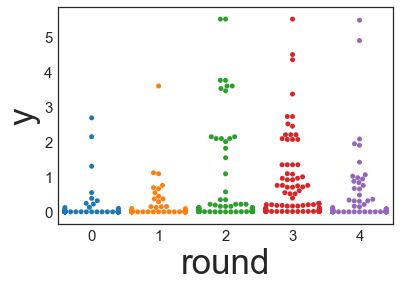

In [15]:
_ = sns.swarmplot(data=df, x='round', y='y')

In [16]:
[max(yy) for yy in y_sampled]

[0.42967125497365644,
 0.5565132206955481,
 0.7415991120426146,
 0.7415991120426146,
 0.7390722631861172]

In [46]:
[opt.get_N(lib, L) for lib in libraries]

[4752, 80, 96, 1008]